Whole notebook has been run on Paperspace Gradient,

created by: Michał Chrzanowski 2022

In [1]:
#modules not used in this notebook but may come in handy later

# image processing of images
from skimage.color import rgb2hsv, hsv2rgb
def color_isolate(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv = rgb2hsv(img[:,:,:3])   
    #MASK
    mask_1 = img_hsv [:,:,0] > 200/360
    mask_2 = img_hsv [:,:,0] < 280/360
    saturation_1 = img_hsv [:,:,1] > 0.35
    saturation_2 = img_hsv [:,:,1] < 0.70
    
    mask= mask_1*mask_1*saturation_1*saturation_2

    image_filtered = np.dstack((img[:,:,0]*mask,
                                img[:,:,1]*mask,
                                img[:,:,2]*mask))

    return image_filtered

#used to preview images loaded in model
def imshow(img):
    npimg = img.numpy()[0]
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

In [2]:
!lsb_release -a #Linux info
!cat /proc/cpuinfo # CPU info
!df -h #disc info
!cat /proc/meminfo #RAM info
!sudo apt install speedtest-cli #library for speedtesting
!speedtest-cli # network speed test

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.4 LTS
Release:	20.04
Codename:	focal
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 106
model name	: Intel(R) Xeon(R) Gold 5315Y CPU @ 3.20GHz
stepping	: 6
microcode	: 0xd000331
cpu MHz		: 3199.806
cache size	: 12288 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 8
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch cpuid_fault pti ibpb fsgsbase bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 xsaves umip rdpid
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit mmio_stale_data
bogomips	: 

In [3]:
!nvidia-smi #GPU info

Thu Oct 27 19:41:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   40C    P8    14W / 140W |      0MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
# Imports
import time
import torch
import torchvision  # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.transforms as transforms  # Transformations and augmentations
from torch import optim  # For optimizers
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader #Dataloader module
from torch.utils.data import Dataset # Dataset module
import torchvision.transforms as transforms
import torchvision.utils as vutils # for presentation of images in a grid
from tqdm import tqdm #nice progress bar
import pandas as pd
import numpy as np
from skimage.io import imshow, imread
import matplotlib.pyplot as plt

# Libraries for dataloader
from os import listdir
from os.path import isfile, join
from PIL import Image
import cv2
#Checking whether GPU RAM is empty
print('allocated CUDA memory: ',torch.cuda.memory_allocated())
print('cached CUDA memory: ',torch.cuda.memory_cached())
# I decided to use external plotting service Weights and biases. It provides easy live preview of model state and  allows convenient runs comparasion
!pip install wandb
!wandb login 33cccacf373072ab6a5edc82d4770dddf40d42fb
import wandb
#%matplotlib inline

allocated CUDA memory:  0
cached CUDA memory:  0


/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
## Hyper-parameters
root = '/notebooks/dataset2-master/dataset2-master/images'
in_channels = 3
num_classes = 4
learning_rate = 9e-4 # got out of local minima with 9e-4, less than this value seams not to work at all or poorly at most.
batch_size = 32
num_epochs = 100
weight_decay = 0.001 # for ADAM optimizer

from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y")
# path to save pytorch models during training
PATH = f'/notebooks/logs/model_{dt_string}.pt'

wandb.init(config={
'root': '/notebooks/dataset2-master/dataset2-master/images',
'in_channels': in_channels,
'num_classes': num_classes,
'learning_rate': learning_rate,
'batch_size': batch_size,
'num_epochs': num_epochs,
'weight_decay': weight_decay
})

wandb: Currently logged in as: chrzanowski000. Use `wandb login --relogin` to force relogin


In [ ]:
"""from PIL import Image
import os,time
import cv2

#img_dir='/notebooks/DATA'
def verify_folder(folder_dir):
    
    def verify_image(img_file):
         #test image
         try:
            v_image = Image.open(img_file)
            v_image.verify()
            return True;
            #is valid
            #print("valid file: "+img_file)
         except OSError:
            return False;

    for root, dirs, files in os.walk(folder_dir):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                currentFile=os.path.join(root, file)
                #print(currentFile)
                #test image
                if verify_image(currentFile):
                    im = cv2.imread(currentFile)
                    if im.shape[0] < 64 or im.shape[1] < 64:
                        print('undersized file')
                        os.remove(currentFile)
                else:
                    os.remove(currentFile)
                    print("corrupt file")
                    
            else:
                os.remove(os.path.join(root, file))
                print("unsupported file extension")
    print('DONE')
                    
verify_folder('/notebooks/dataset2-master/dataset2-master/images')""";

In [3]:
# DATALOADERS

# Train Loader
class BloodCell_train(Dataset):
    def __init__(self, root ,transform):
        self.labels = []
        self.dirName_1 = join(root,'TRAIN/EOSINOPHIL') # path to training data with EOSINOPHILS cells
        self.dirName_2 = join(root,'TRAIN/LYMPHOCYTE') # path to training data with LYMPHOCYTES cells
        self.dirName_3 = join(root,'TRAIN/MONOCYTE') # path to training data with MONOCYTES cells
        self.dirName_4 = join(root,'TRAIN/NEUTROPHIL') # path to training data with NEUTROPHILS cells
        self.files_names = []
        self.transform = transform
        self.load_images()
    

    def load_images(self):

        # create list of paths to images
        files_1 = [join(self.dirName_1, f) for f in listdir(self.dirName_1) if isfile(join(self.dirName_1, f))]
        files_2 = [join(self.dirName_2, f) for f in listdir(self.dirName_2) if isfile(join(self.dirName_2, f))]
        files_3 = [join(self.dirName_3, f) for f in listdir(self.dirName_3) if isfile(join(self.dirName_3, f))]
        files_4 = [join(self.dirName_4, f) for f in listdir(self.dirName_4) if isfile(join(self.dirName_4, f))]
        

        # connect lists of different cells in one big list
        self.files_names = files_1 + files_2 + files_3 + files_4

        # creating label list
        for file_name in files_1:
            self.labels.append(0)

        for file_name in files_2:
            self.labels.append(1)

        for file_name in files_3:
            self.labels.append(2)

        for file_name in files_4:
            self.labels.append(3)

        del files_1
        del files_2
        del files_3
        del files_4

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image=cv2.imread(self.files_names[index])
        #image = color_isolate(image.astype(np.float32))
        y_label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

# Test Loader
class BloodCell_test(Dataset):
    def __init__(self, root,transform):
        self.labels = []
        self.dirName_1 = join(root,'TEST/EOSINOPHIL') # path to test data with EOSINOPHILS cells
        self.dirName_2 = join(root,'TEST/LYMPHOCYTE') # path to test data with LYMPHOCYTES cells
        self.dirName_3 = join(root,'TEST/MONOCYTE') # path to test data with MONOCYTES cells
        self.dirName_4 = join(root,'TEST/NEUTROPHIL') # path to test data with NEUTROPHILS cellsself.files_names = []
        self.files_names = []
        self.transform = transform
        self.load_images()
        

    def load_images(self):

        # create list of paths to images
        files_1 = [join(self.dirName_1, f) for f in listdir(self.dirName_1) if isfile(join(self.dirName_1, f))]
        files_2 = [join(self.dirName_2, f) for f in listdir(self.dirName_2) if isfile(join(self.dirName_2, f))]
        files_3 = [join(self.dirName_3, f) for f in listdir(self.dirName_3) if isfile(join(self.dirName_3, f))]
        files_4 = [join(self.dirName_4, f) for f in listdir(self.dirName_4) if isfile(join(self.dirName_4, f))]
        
        # connect lists of different cells in one big list
        self.files_names = files_1 + files_2 + files_3 + files_4

        # creating label list
        for file_name in files_1:
            self.labels.append(0)

        for file_name in files_2:
            self.labels.append(1)

        for file_name in files_3:
            self.labels.append(2)

        for file_name in files_4:
            self.labels.append(3)

        del files_1
        del files_2
        del files_3
        del files_4
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image=cv2.imread(self.files_names[index])
        #image = color_isolate(image.astype(np.float32))
        y_label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, y_label)


100%|██████████| 2487/2487 [00:05<00:00, 472.40it/s]


TRAIN dataset ,mean: [0.6604949235916138, 0.6413165926933289, 0.6786165833473206], std: [0.2611522078514099, 0.26364096999168396, 0.2644507884979248]
TEST dataset ,mean: [0.6609439253807068, 0.640540361404419, 0.6794524192810059], std: [0.2606455385684967, 0.2622940242290497, 0.26362478733062744]


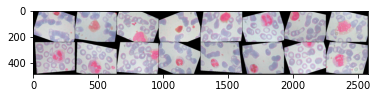

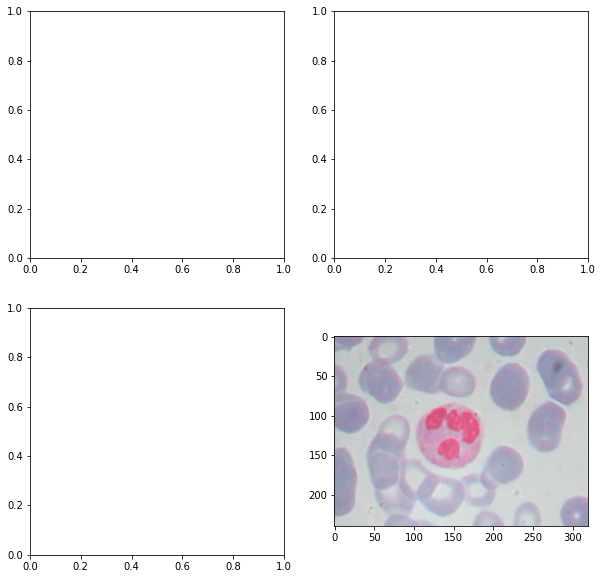

In [6]:
# for calcualting mean and std od dataset
def get_mean_and_std(dataset):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(dataset):
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[1,2])
        channels_squared_sum += torch.mean(data**2, dim=[1,2])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

Norm_transform = transforms.Compose([transforms.ToTensor()])
Norm_dataset_train = BloodCell_train(root=root,transform=Norm_transform)
Norm_dataset_test = BloodCell_test(root=root,transform=Norm_transform)

mean_train, std_train = get_mean_and_std(Norm_dataset_train)
mean_test, std_test = get_mean_and_std(Norm_dataset_test)

Norm_dataloader_train = torch.utils.data.DataLoader(dataset=Norm_dataset_train, batch_size=16, shuffle=True, num_workers=1)
Norm_loaded_images=next(iter(Norm_dataloader_train))[0]
loaded_images_array = np.transpose(vutils.make_grid(Norm_loaded_images, padding=2, normalize=True).cpu().detach().numpy(),(1,2,0))
plt.imshow(loaded_images_array)

del Norm_dataloader_train, Norm_dataset_train, Norm_dataset_test
print(f'TRAIN dataset ,mean: {mean_train.tolist()}, std: {std_train.tolist()}')
print(f'TEST dataset ,mean: {mean_test.tolist()}, std: {std_test.tolist()}')


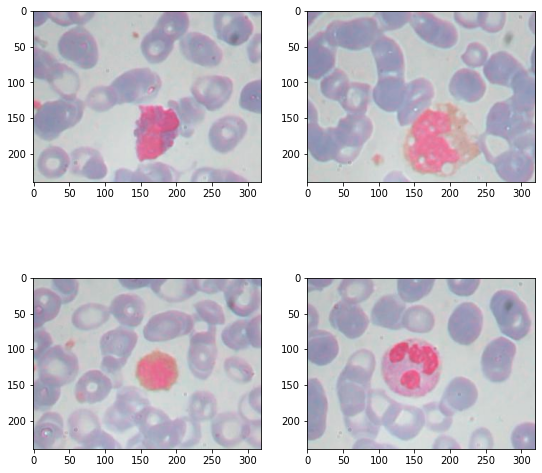

In [27]:

image_EOSINOPHIL = cv2.imread('/notebooks/dataset2-master/dataset2-master/images/TEST_SIMPLE/EOSINOPHIL/_11_9310.jpeg')
image_LYMPHOCYTE = cv2.imread('/notebooks/dataset2-master/dataset2-master/images/TEST_SIMPLE/LYMPHOCYTE/_2_6981.jpeg')
image_MONOCYTE = cv2.imread('/notebooks/dataset2-master/dataset2-master/images/TEST_SIMPLE/MONOCYTE/_2_4392.jpeg')
image_NEUTROPHIL = cv2.imread('/notebooks/dataset2-master/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL/_14_4489.jpeg')

f, axes = plt.subplots(2,2, figsize=(9,9))
axes[0,0].imshow(image_EOSINOPHIL)
axes[1,0].imshow(image_LYMPHOCYTE)
axes[0,1].imshow(image_MONOCYTE)
axes[1,1].imshow(image_NEUTROPHIL);



In [ ]:
# model creation
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=9,
            kernel_size=(11, 11),
            stride=(1, 1),
            padding=(1,1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=9,
            out_channels=27,
            kernel_size=(7, 7),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv3 = nn.Conv2d(
            in_channels=27,
            out_channels=54,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv4 = nn.Conv2d(
            in_channels=54,
            out_channels=54,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(1,1),
        )
        self.conv5 = nn.Conv2d(
            in_channels=54,
            out_channels=108,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv6 = nn.Conv2d(
            in_channels=108,
            out_channels=108,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv7 = nn.Conv2d(
            in_channels=108,
            out_channels=108,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv8 = nn.Conv2d(
            in_channels=108,
            out_channels=108,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(0,0),
        )

        self.pool5 = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.drop1d = nn.Dropout(0.1)
        self.BatchNorm2d1 = nn.BatchNorm2d(num_features=9)
        self.BatchNorm2d3 = nn.BatchNorm2d(num_features=54)
        self.fc1 = nn.Linear(41472, 5000)
        self.fc2 = nn.Linear(5000, 5000)
        self.fc3 = nn.Linear(5000, 5000)
        self.fc4 = nn.Linear(5000, num_classes)

    def forward(self, x):
        x = F.leaky_relu(self.BatchNorm2d1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.BatchNorm2d3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = self.pool5(x)
        x = F.leaky_relu(self.conv5(x), 0.2)
        x = F.leaky_relu(self.conv6(x), 0.2)
        x = F.leaky_relu(self.conv7(x), 0.2)
        x = self.pool2(x)
        x = F.leaky_relu(self.conv8(x), 0.2)
        x = x.reshape(x.shape[0], -1)

        # worked without dropouts
        x = self.fc1(x)
        x = self.drop1d(x)
        x = self.fc2(x)
        x = self.drop1d(x)
        x = self.fc3(x)
        x = self.drop1d(x)
        x = self.fc4(x)
        return x

In [ ]:
# calculate outputs shape of layers
W=320
H=240
print('initial shape',W,H)
#1st conv
W=(W-11+2*1)/1+1
H=(H-11+2*1)/1+1
print('after 1st conv',W,H)
# 2st conv
W=(W-7+2*0)/1+1
H=(H-7+2*0)/1+1
print('after 2nd conv',W,H)
# 3nd conv
W=(W-5+2*0)/1+1
H=(H-5+2*0)/1+1
print('after 3rd conv',W,H)
# 4nd conv#
W=(W-5+2*1)/1+1
H=(H-5+2*1)/1+1
print('after 4th conv',W,H)
# pool5
W=W/5
H=H/5
print('after 1st pooling',W,H)
# 5nd conv
W=(W-5+2*0)/1+1
H=(H-5+2*0)/1+1
print('after 5th conv',W,H)
# 6nd conv
W=(W-3+2*0)/1+1
H=(H-3+2*0)/1+1
print('after 6th conv',W,H)
# 7nd conv
W=(W-3+2*0)/1+1
H=(H-3+2*0)/1+1
print('after 7th conv',W,H)
# pool2
W=W/2
H=H/2
print('after 2nd pooling',W,H)
# 8nd conv
W=(W-3+2*0)/1+1
H=(H-3+2*0)/1+1
print('after 8th conv',W,H)

number_out_channels = 108
print('Size of end output',H*W*number_out_channels)


initial shape 320 240
after 1st conv 312.0 232.0
after 2nd conv 306.0 226.0
after 3rd conv 302.0 222.0
after 4th conv 300.0 220.0
after 1st pooling 60.0 44.0
after 5th conv 56.0 40.0
after 6th conv 54.0 38.0
after 7th conv 52.0 36.0
after 2nd pooling 26.0 18.0
after 8th conv 24.0 16.0
Size of end output 41472.0


In [ ]:
torch.cuda.empty_cache()
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using: {device}')
torch.backends.cudnn.benchmark = True #let cudnn chose the most efficient way of calculating Convolutions

#Connenting to wandb project to log data there
import wandb
#wandb.init(mode="disabled")
wandb.init(project="CNN_BloodCell_3")

# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes)
model.to(device) 

# define transformations for datasets, stds and means have been calculated before with cell above on dataloaders without normalization
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean_train,std_train)])
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean_test, std_test)])

#initialize datasets and dataloaders
dataset_train = BloodCell_train(root=root, transform=transform_train)
dataset_test = BloodCell_test(root=root, transform=transform_test)

# set shuffle = True to randomize order
# To avoid blocking computation code with data loading we set num_workers = 2
# pin_memory = True will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Calculate number of learnable parameters in our model
mode_par_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trained parameters in model: " + '{:,}'.format(mode_par_num).replace(',', ' '))

using: cuda


Number of trained parameters in model: 257 980 958


In [ ]:
# Check accuracy faster than metrics function
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    # Add more metrics as F1 and F2, ACC, PREC
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        ACC = num_correct / num_samples


    model.train()
    return ACC

# calculates full model metrics report
def metrics(loader, model):
    from sklearn import metrics
    model.eval()
    with torch.no_grad():
        predictions = np.array([])
        targets = np.array([])
        for x, y in tqdm(loader):
            x = x.to(device=device)
            targets_batch = y.to(device=device)

            scores = model(x)
            _, predictions_batch = scores.max(1)
            predictions = np.append(predictions, predictions_batch.cpu().detach().numpy())
            targets = np.append(targets, targets_batch.cpu().detach().numpy())

        # the precision and recall, among other metrics
        metrics_table=metrics.classification_report(targets, predictions, digits=4)

    model.train()
    return metrics_table

In [ ]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
#optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
start_time = time.time()
# Optional
wandb.watch(model, criterion, log="all", log_freq=400)
train_acc_best = 0
test_acc_best = 0
# Train Network

# lines balow allow to load previously trained model
checkpoint = torch.load('/notebooks/logs/model_26_10_2022-model-opt(87).pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")    
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")
print('train loader:', metrics(train_loader, model))
print('test loader:', metrics(test_loader, model))


for epoch in tqdm(range(num_epochs)):
    print(f'epoch nr {epoch}')
    for data, targets in train_loader:
        # Get data to device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward and loss calculation
        scores=model(data)
        loss = criterion(scores, targets)
        # log loss to wandb
        wandb.log({"loss": loss})

        # backward
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # setting parameteres gradients to None, takes less memory than setting to '0'
        for param in model.parameters():
            param.grad = None
    
    # Calculate Accuracy and save model if test acc has increased
    train_acc = check_accuracy(train_loader, model)*100
    test_acc = check_accuracy(test_loader, model)*100
    if test_acc > test_acc_best:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)
        test_acc_best = test_acc
        train_acc_best = train_acc
        print(f'model saved: train_acc: {train_acc_best}, test_acc: {test_acc_best}')

    # log train_acc and test_acc to wandb
    wandb.log({"train_acc": train_acc})
    wandb.log({"test_acc": test_acc})
    print(f"Accuracy on training set: {train_acc:.2f}")    
    print(f"Accuracy on test set: {test_acc:.2f}")

    #print('cached CUDA memory: ',torch.cuda.memory_cached())
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']
print("--- %s seconds ---" % (time.time() - start_time))
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")    
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")
print('train loader:', metrics(train_loader, model))
print('test loader:', metrics(test_loader, model))


Accuracy on training set: 88.48
Accuracy on test set: 87.17


100%|██████████| 312/312 [00:20<00:00, 15.30it/s]


train loader:               precision    recall  f1-score   support

         0.0     0.8193    0.8590    0.8387      2497
         1.0     0.8900    0.9807    0.9331      2483
         2.0     0.9654    0.8894    0.9259      2478
         3.0     0.8733    0.8107    0.8408      2499

    accuracy                         0.8848      9957
   macro avg     0.8870    0.8850    0.8846      9957
weighted avg     0.8868    0.8848    0.8845      9957



100%|██████████| 78/78 [00:04<00:00, 16.48it/s]


test loader:               precision    recall  f1-score   support

         0.0     0.8508    0.9518    0.8985       623
         1.0     0.9762    0.9919    0.9840       620
         2.0     0.9432    0.7500    0.8356       620
         3.0     0.7421    0.7933    0.7668       624

    accuracy                         0.8717      2487
   macro avg     0.8781    0.8718    0.8712      2487
weighted avg     0.8778    0.8717    0.8711      2487



  0%|          | 0/100 [00:00<?, ?it/s]

epoch nr 0


  1%|          | 1/100 [01:53<3:06:40, 113.14s/it]

model saved: train_acc: 24.48528480529785, test_acc: 25.53277015686035
Accuracy on training set: 24.49
Accuracy on test set: 25.53
epoch nr 1


  2%|▏         | 2/100 [03:43<3:02:18, 111.62s/it]

model saved: train_acc: 35.151145935058594, test_acc: 31.845596313476562
Accuracy on training set: 35.15
Accuracy on test set: 31.85
epoch nr 2


  3%|▎         | 3/100 [05:33<2:59:09, 110.82s/it]

model saved: train_acc: 36.456764221191406, test_acc: 34.258140563964844
Accuracy on training set: 36.46
Accuracy on test set: 34.26
epoch nr 3


  4%|▍         | 4/100 [07:22<2:56:22, 110.23s/it]

model saved: train_acc: 38.254493713378906, test_acc: 38.52030563354492
Accuracy on training set: 38.25
Accuracy on test set: 38.52
epoch nr 4


  5%|▌         | 5/100 [09:06<2:50:40, 107.79s/it]

Accuracy on training set: 42.19
Accuracy on test set: 38.44
epoch nr 5


  6%|▌         | 6/100 [10:50<2:46:48, 106.47s/it]

Accuracy on training set: 41.36
Accuracy on test set: 35.75
epoch nr 6


  8%|▊         | 8/100 [14:16<2:40:09, 104.45s/it]

Accuracy on training set: 41.58
Accuracy on test set: 34.62
epoch nr 8


  9%|▉         | 9/100 [16:05<2:40:54, 106.09s/it]

model saved: train_acc: 40.363563537597656, test_acc: 40.249298095703125
Accuracy on training set: 40.36
Accuracy on test set: 40.25
epoch nr 9


 10%|█         | 10/100 [17:49<2:37:48, 105.21s/it]

Accuracy on training set: 45.57
Accuracy on test set: 34.50
epoch nr 10


 11%|█         | 11/100 [19:33<2:35:37, 104.91s/it]

Accuracy on training set: 38.14
Accuracy on test set: 34.86
epoch nr 11


 12%|█▏        | 12/100 [21:17<2:33:22, 104.57s/it]

Accuracy on training set: 40.13
Accuracy on test set: 27.91
epoch nr 12


 13%|█▎        | 13/100 [22:58<2:30:22, 103.71s/it]

Accuracy on training set: 43.60
Accuracy on test set: 34.70
epoch nr 13


 14%|█▍        | 14/100 [24:42<2:28:40, 103.73s/it]

Accuracy on training set: 41.62
Accuracy on test set: 31.08
epoch nr 14


 15%|█▌        | 15/100 [26:48<2:36:21, 110.37s/it]

Accuracy on training set: 40.61
Accuracy on test set: 32.85
epoch nr 15


 16%|█▌        | 16/100 [28:31<2:31:40, 108.34s/it]

Accuracy on training set: 34.55
Accuracy on test set: 32.57
epoch nr 16


 17%|█▋        | 17/100 [30:14<2:27:22, 106.53s/it]

Accuracy on training set: 31.24
Accuracy on test set: 28.19
epoch nr 17


 18%|█▊        | 18/100 [31:58<2:24:33, 105.78s/it]

Accuracy on training set: 36.30
Accuracy on test set: 28.75
epoch nr 18


 19%|█▉        | 19/100 [33:41<2:21:56, 105.14s/it]

Accuracy on training set: 28.53
Accuracy on test set: 26.82
epoch nr 19


 20%|██        | 20/100 [35:26<2:19:46, 104.83s/it]

Accuracy on training set: 41.99
Accuracy on test set: 33.53
epoch nr 20


 21%|██        | 21/100 [37:08<2:16:52, 103.96s/it]

Accuracy on training set: 28.63
Accuracy on test set: 28.07
epoch nr 21


 22%|██▏       | 22/100 [38:51<2:15:07, 103.95s/it]

Accuracy on training set: 41.68
Accuracy on test set: 34.74
epoch nr 22


 23%|██▎       | 23/100 [40:35<2:13:16, 103.85s/it]

Accuracy on training set: 37.40
Accuracy on test set: 32.25
epoch nr 23


 24%|██▍       | 24/100 [42:19<2:11:36, 103.90s/it]

Accuracy on training set: 42.07
Accuracy on test set: 29.59
epoch nr 24


 25%|██▌       | 25/100 [44:01<2:09:05, 103.27s/it]

Accuracy on training set: 34.87
Accuracy on test set: 32.45
epoch nr 25


 27%|██▋       | 27/100 [47:29<2:05:59, 103.56s/it]

Accuracy on training set: 39.49
Accuracy on test set: 36.15
epoch nr 27


 28%|██▊       | 28/100 [49:13<2:04:30, 103.76s/it]

Accuracy on training set: 46.29
Accuracy on test set: 34.50
epoch nr 28


 29%|██▉       | 29/100 [50:55<2:02:09, 103.23s/it]

Accuracy on training set: 26.00
Accuracy on test set: 24.05
epoch nr 29


 30%|███       | 30/100 [52:39<2:00:41, 103.45s/it]

Accuracy on training set: 27.28
Accuracy on test set: 25.21
epoch nr 30


 31%|███       | 31/100 [54:23<1:59:08, 103.60s/it]

Accuracy on training set: 33.52
Accuracy on test set: 32.01
epoch nr 31


 32%|███▏      | 32/100 [56:06<1:57:27, 103.64s/it]

Accuracy on training set: 28.58
Accuracy on test set: 25.49
epoch nr 32


 33%|███▎      | 33/100 [57:48<1:55:05, 103.07s/it]

Accuracy on training set: 40.62
Accuracy on test set: 37.47
epoch nr 33


 34%|███▍      | 34/100 [59:32<1:53:43, 103.39s/it]

Accuracy on training set: 39.00
Accuracy on test set: 34.26
epoch nr 34


 35%|███▌      | 35/100 [1:01:16<1:52:09, 103.53s/it]

Accuracy on training set: 39.18
Accuracy on test set: 36.19
epoch nr 35


 36%|███▌      | 36/100 [1:03:00<1:50:33, 103.64s/it]

Accuracy on training set: 43.64
Accuracy on test set: 39.08
epoch nr 36


 37%|███▋      | 37/100 [1:04:42<1:48:11, 103.04s/it]

Accuracy on training set: 37.90
Accuracy on test set: 34.30
epoch nr 37


 38%|███▊      | 38/100 [1:06:26<1:46:44, 103.31s/it]

Accuracy on training set: 43.46
Accuracy on test set: 38.32
epoch nr 38


 39%|███▉      | 39/100 [1:08:09<1:45:13, 103.49s/it]

Accuracy on training set: 42.03
Accuracy on test set: 34.62
epoch nr 39


 40%|████      | 40/100 [1:09:53<1:43:34, 103.57s/it]

Accuracy on training set: 40.88
Accuracy on test set: 34.82
epoch nr 40


 41%|████      | 41/100 [1:11:35<1:41:21, 103.08s/it]

Accuracy on training set: 37.66
Accuracy on test set: 33.78
epoch nr 41


 42%|████▏     | 42/100 [1:13:19<1:39:49, 103.26s/it]

Accuracy on training set: 36.03
Accuracy on test set: 30.32
epoch nr 42


 43%|████▎     | 43/100 [1:15:03<1:38:23, 103.58s/it]

Accuracy on training set: 38.32
Accuracy on test set: 33.57
epoch nr 43


 44%|████▍     | 44/100 [1:16:47<1:36:50, 103.76s/it]

Accuracy on training set: 35.93
Accuracy on test set: 31.93
epoch nr 44


 45%|████▌     | 45/100 [1:18:29<1:34:37, 103.23s/it]

Accuracy on training set: 40.26
Accuracy on test set: 35.71
epoch nr 45


 46%|████▌     | 46/100 [1:20:13<1:33:04, 103.41s/it]

Accuracy on training set: 35.99
Accuracy on test set: 32.89
epoch nr 46


 47%|████▋     | 47/100 [1:21:57<1:31:25, 103.49s/it]

Accuracy on training set: 42.46
Accuracy on test set: 38.76
epoch nr 47


 48%|████▊     | 48/100 [1:23:41<1:29:53, 103.73s/it]

Accuracy on training set: 38.32
Accuracy on test set: 36.11
epoch nr 48


 49%|████▉     | 49/100 [1:25:23<1:27:41, 103.16s/it]

Accuracy on training set: 37.44
Accuracy on test set: 33.25
epoch nr 49


 50%|█████     | 50/100 [1:27:07<1:26:09, 103.38s/it]

Accuracy on training set: 38.83
Accuracy on test set: 39.36
epoch nr 50


 51%|█████     | 51/100 [1:28:57<1:26:02, 105.35s/it]

model saved: train_acc: 45.79692459106445, test_acc: 40.57096862792969
Accuracy on training set: 45.80
Accuracy on test set: 40.57
epoch nr 51


 51%|█████     | 51/100 [1:29:51<1:26:20, 105.72s/it]


KeyboardInterrupt: 

In [ ]:
"""model.load_state_dict(torch.load('/notebooks/logs/model_26_10_2022-Copy1.pt'))
train_acc = check_accuracy(train_loader, model)*100
test_acc = check_accuracy(test_loader, model)*100
print(f"Accuracy on training set: {train_acc:.2f}")    
print(f"Accuracy on test set: {test_acc:.2f}")"""